In [1]:
import tqdm
import numpy as np
import torch
from torch import nn, optim
from types import SimpleNamespace
import matplotlib.pyplot as plt
from plotting_funcs import *
from dynamics import Dynamics
from nn_models import ODEFunc_t
from utils import get_batch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [39]:
# 0. setting up parameters for training
args_dict = {'method': 'rk4',   # solver
             'data_size': 800, # number of data points per trajectory
             'batch_time': 2,   # look forward
             'niters': 5,   # num of iterations for training 5000
             'test_freq': 50,   # frequency of testing and generating plots
             'viz': True,       # Whether to visualise the data
             'time_steps': 50,  #Trajectory Time Steps
             'adjoint': False,
             'gyre_type': 'double', # 'single' and 'double'
             'num_traj': 4,  # number of trajectories in the dataset # if single gyre with 1 trajectory then 1
             'save_data': False,
             'model_type':'NODE', # 'NODE', 'KNODE', 'ANODE'
             'flow_type': 'time-variant', # 'time-invariant', 'time-variant'
             'debug_level': 1,# debug_level: 0 --> no debugging, debug_level: 1--> quiver plots of trajectories
             'animate_time':10, #length of animation for time-varying double gyro
             'animate_dt':1, #dt of animation for time-varying double gyro
             'save_gif':False } #Save gif of true and predicted time-varying double gyro
             
args = SimpleNamespace(**args_dict)

In [3]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

if args.gyre_type == 'single':
    plot_path = "Single_Gyre"
if args.gyre_type == 'double':
    plot_path = "Double_Gyre"

if args.flow_type == 'time-invariant':
    plot_path_t = "Inv_"
if args.flow_type == 'time-variant':
    plot_path_t = "Var_"

In [4]:
# 1. Define the experiment: Single Gyre or Double Gyre
if args.gyre_type == 'single':
 # Generate Ground Truth for Training:
    # 1. Set Initial Condition for trajectory
    true_init_cond_traj_1        =   torch.tensor([[-49.0, 10]]).to(device)
    # 2. Generate time steps for trajectory
    true_time_traj_1             =   torch.linspace(0.0, args.time_steps, args.data_size).to(device)
    # 3. Generate "True" Trajectory for n time steps
    with torch.no_grad():
        true_traj_1              =  odeint(Dynamics(), true_init_cond_traj_1, true_time_traj_1, method=args.method, options=dict(step_size=0.02)).to(device)
    # 4. Add time decaying Gaussian noise to the trajectory
    # TODO:
    # Change the format of the true_traj below
    true_y                    = torch.cat([true_traj_1 .squeeze()]).unsqueeze(1)
    t                         = torch.cat([true_time_traj_1.squeeze()])
    traj_lengths              = [true_traj_1.shape[0]]
    # Setting up visulisation
    if args.viz:
        # 1. Visualize True Trajectory overlaid with  Vector Field
        visualize_true_single_gyre( t, true_y, device, args.model_type, flow_type = plot_path_t )

elif args.gyre_type == 'double':
 # Generate Ground Truth for Training:
    # 1. Set Initial Condition for trajectory
    true_init_cond_traj_1    = torch.tensor([[-49.0, 10]]).to(device)
    true_init_cond_traj_2    = torch.tensor([[49.0, 10]]).to(device)
    true_init_cond_traj_3    = torch.tensor([[-48.0, 11]]).to(device)
    true_init_cond_traj_4    = torch.tensor([[48.0, 11]]).to(device)
    np.random.seed(1)
    true_init_cond_traj = np.zeros((args.num_traj,2))
    #left gyro
    for i in range(int(args.num_traj/2)):
        x_ini = np.random.uniform(low=-50, high=0.0)
        y_ini = np.random.uniform(low=0, high=50)
        true_init_cond_traj[i] = np.array([x_ini,y_ini])
    #right gyro
    for i in range(int(args.num_traj/2)):
        x_ini = np.random.uniform(low=0.0, high=50)
        y_ini = np.random.uniform(low=0, high=50)
        true_init_cond_traj[int(args.num_traj/2)+i] = np.array([x_ini,y_ini])

    true_init_cond_traj = torch.tensor(true_init_cond_traj).to(device)

    # print(true_init_cond_traj)
    # exit()

In [5]:

    # 2. Generate time steps for trajectory
    true_time_traj_1         = torch.linspace(0.0, args.time_steps, args.data_size).to(device)
    true_time_traj_2         = torch.linspace(0.0, args.time_steps, args.data_size).to(device)
    true_time_traj        = torch.linspace(0.0, args.time_steps, args.data_size).to(device)
    
    # 3. Generate "True" Trajectory for n time steps
    with torch.no_grad():
        true_traj_1          = odeint(Dynamics(), true_init_cond_traj_1, true_time_traj_1, method=args.method,
                             options=dict(step_size=0.02)).to(device)
        true_traj_2          = odeint(Dynamics(), true_init_cond_traj_2, true_time_traj_2, method=args.method,
                             options=dict(step_size=0.02)).to(device)
        true_traj_3          = odeint(Dynamics(), true_init_cond_traj_3, true_time_traj_1, method=args.method,
                             options=dict(step_size=0.02)).to(device)
        true_traj_4          = odeint(Dynamics(), true_init_cond_traj_4, true_time_traj_2, method=args.method,
                             options=dict(step_size=0.02)).to(device)
        # for i in range(args.num_traj):
        #     true_time_traj_i = odeint(Dynamics(), true_time_traj[i], true_time_traj, method=args.method,options=dict(step_size=0.02)).to(device)

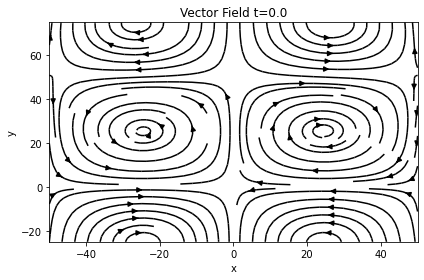

In [8]:
    # 4. Add Gaussian noise to the trajectory
    # TODO
    # 5. Collect both trajectories
    # true_y                    = torch.cat([true_traj_1.squeeze(), true_traj_2.squeeze()]).unsqueeze(1)
    # t                         = torch.cat([true_time_traj_1.squeeze(), true_time_traj_2.squeeze()])
    # traj_lengths              = [true_traj_1.shape[0], true_traj_2.shape[0]]
    true_y                    = torch.cat([true_traj_1.squeeze(), true_traj_2.squeeze(), true_traj_3.squeeze(), true_traj_4.squeeze()]).unsqueeze(1)
    t                         = torch.cat([true_time_traj_1.squeeze(), true_time_traj_2.squeeze(), true_time_traj_1.squeeze(), true_time_traj_2.squeeze()])
    traj_lengths              = [true_traj_1.shape[0], true_traj_2.shape[0], true_traj_3.shape[0], true_traj_4.shape[0]]
    # 6.
    if args.viz:
        # 1. Visualize True Trajectories overlaid with  Vector Field
        if args.flow_type == 'time-variant':
            # Close the figure 1 when you want to run the  
            visualize_true_time_var_double_gyre(device, args.animate_time, args.animate_dt, flow_type= plot_path_t, model_type=args.model_type, save_gif=args.save_gif)
        else:
            visualize_true_double_gyre(true_time_traj_1 , true_traj_1, true_time_traj_2 , true_traj_2, device, args.model_type, flow_type= plot_path_t )


In [37]:
true_y_cat = torch.tensor([]).to(device)
for i in range(args.num_traj):
# for i in range(2):
    true_time_traj_i = odeint(Dynamics(), true_init_cond_traj[i].unsqueeze(0), true_time_traj, method=args.method,options=dict(step_size=0.02)).to(device)
    true_y_cat = torch.cat([true_y_cat, true_time_traj_i.squeeze()])

true_y_cat = true_y_cat.unsqueeze(1)

In [32]:
t_cat = torch.tensor([]).to(device)
for i in range(args.num_traj):
    t_cat = torch.cat([t_cat, true_time_traj.squeeze()])

In [54]:
traj_lengths = [args.data_size]*args.num_traj
print(traj_lengths)

[800, 800, 800, 800]


In [38]:
# 4.  Create Neural ODE, set optimizer and loss functions
func        = ODEFunc_t(device).to(device)
knowledge   = Dynamics().to(device)
optimizer   = optim.Adam(func.parameters(), lr=1e-3)#lr=1e-2 to 1e-3
lossMSE     = nn.MSELoss()

In [45]:
# 5. Do training
training_loss = []
cbar_returned = None
for itr in tqdm.tqdm(range(1, args.niters + 1)):
    # forward pass
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y  = get_batch(t, true_y, traj_lengths, args.data_size, args.num_traj, args.batch_time, device)
    print(batch_y0.shape, batch_t, batch_y.shape)
    pred_y                      = odeint(func, batch_y0, batch_t, method=args.method, options=dict(step_size=0.02)).to(device)

100%|██████████| 5/5 [00:00<00:00, 88.85it/s]

torch.Size([3196, 1, 2]) tensor([0.0000, 0.0626]) torch.Size([2, 3196, 1, 2])
torch.Size([3196, 1, 2]) tensor([0.0000, 0.0626]) torch.Size([2, 3196, 1, 2])
torch.Size([3196, 1, 2]) tensor([0.0000, 0.0626]) torch.Size([2, 3196, 1, 2])
torch.Size([3196, 1, 2]) tensor([0.0000, 0.0626]) torch.Size([2, 3196, 1, 2])
torch.Size([3196, 1, 2]) tensor([0.0000, 0.0626]) torch.Size([2, 3196, 1, 2])


In [49]:
for itr in tqdm.tqdm(range(1, args.niters + 1)):
    # forward pass
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y  = get_batch(t, true_y_cat, traj_lengths, args.data_size, args.num_traj, args.batch_time, device)
    print(type(batch_t[0]))
    print(batch_y0.shape, batch_t, batch_y.shape)
    pred_y                      = odeint(func, batch_y0, batch_t, method=args.method, options=dict(step_size=0.02)).to(device)

  0%|          | 0/5 [00:00<?, ?it/s]

<class 'torch.Tensor'>
torch.Size([3196, 1, 2]) tensor([0.0000, 0.0626]) torch.Size([2, 3196, 1, 2])


RuntimeError: expected scalar type Float but found Double

In [63]:
batch_y0.shape

torch.Size([3196, 1, 2])

In [58]:
true_y_cat[1]

tensor([[-30.2690,  35.5627]], dtype=torch.float64)

In [62]:
t==t_cat

tensor([True, True, True,  ..., True, True, True])

In [60]:
t_cat

tensor([ 0.0000,  0.0626,  0.1252,  ..., 49.8748, 49.9374, 50.0000])